<a href="https://colab.research.google.com/github/hecshzye/monodepth2_paper_exp_1/blob/main/monodepth_trials_3_custom_data_nebula_redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monodepth2 trials_1

Checking for GPU access 

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0d90b970-2b27-eaec-3c79-4fea2a0dc108)


### Install essentials 

In [2]:
!pip install Pillow==6.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# OpenCV
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Install Tensorflow 
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Install tensorboard
!pip install tensorboardX==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 5.3 MB/s 


In [7]:
# Clone monodepth2 
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [8]:
cd monodepth2

/content/monodepth2


In [9]:
ls

assets/                         experiments/        networks/       trainer.py
datasets/                       export_gt_depth.py  options.py      train.py
depth_prediction_example.ipynb  kitti_utils.py      README.md       utils.py
evaluate_depth.py               layers.py           splits/
evaluate_pose.py                LICENSE             test_simple.py


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
import networks
import seaborn
from utils import download_model_if_doesnt_exist
import PIL.Image as pil 
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow_hub as tf_hub

Do not download the complete dataset because of the size of the file

In [8]:
#!wget -i /content/monodepth2/splits/kitti_archives_to_download.txt -P kitti_data/

--2022-06-08 06:53:27--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.181
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘kitti_data/2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-06-08 06:53:27 (190 MB/s) - ‘kitti_data/2011_09_26_calib.zip’ saved [4068/4068]

--2022-06-08 06:53:27--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Reusing existing connection to s3.eu-central-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Saving to: ‘kitti_data/2011_09_26_drive_0001_sync.zip’

2011_09_26_drive_00 100%[===================>] 437.4

### Test the model

In [11]:
!python /content/monodepth2/test_simple.py --image_path /content/monodepth2/assets/test_image.jpg --model_name mono+stereo_640x192

-> Downloading pretrained model to models/mono+stereo_640x192.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_640x192
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved predictions to:
   - /content/monodepth2/assets/test_image_disp.jpeg
   - /content/monodepth2/assets/test_image_disp.npy
-> Done!


Weights & Network Setups

In [19]:
# Name of the model
model_name = "mono_640x192"

# Fetch the model
download_model_if_doesnt_exist(model_name)

# Define path to the encoder
encoder_path = os.path.join("models", model_name, "encoder.pth")

# Define path to the decoder
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)  # Using ResNet18 & ResNet50 (True)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

# Load the torch model
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

# Evaluate
encoder.eval()
depth_decoder.eval();

Loading the test image & processing

In [28]:
# Path to the image
image_path = "/content/monodepth2/assets/4kimg_13.jpg"

# Open the image using Pillow
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

# Resize
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

# Convert the images to tensor 
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

Predicting using the PyTorch model

In [29]:
# Predict 
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

# Display the output
disp = outputs[("disp", 0)]

Plot

### PLOT_1

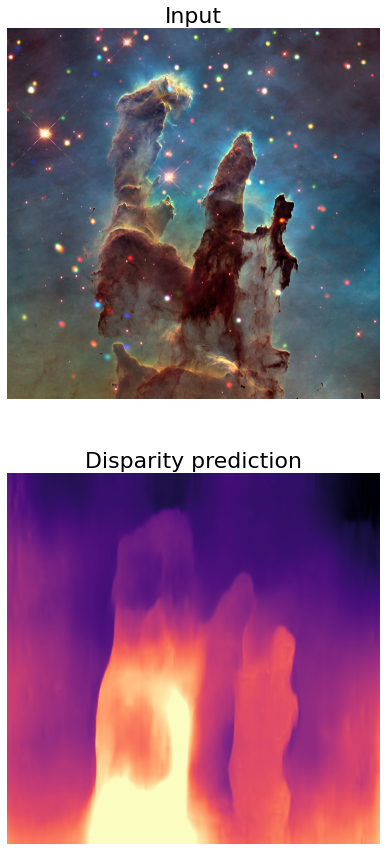

In [30]:

# Use the resized image
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

# Plot
plt.figure(figsize=(15, 15))
plt.subplot(211) 
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### PLOT_2

In [58]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='inferno', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

Error in callback <function flush_figures at 0x7f9a580a80e0> (for post_execute):


KeyboardInterrupt: ignored

### PLOT_3

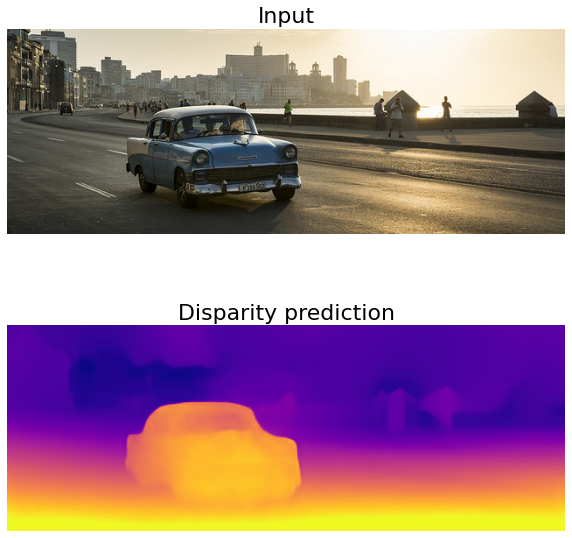

In [19]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### PLOT_4

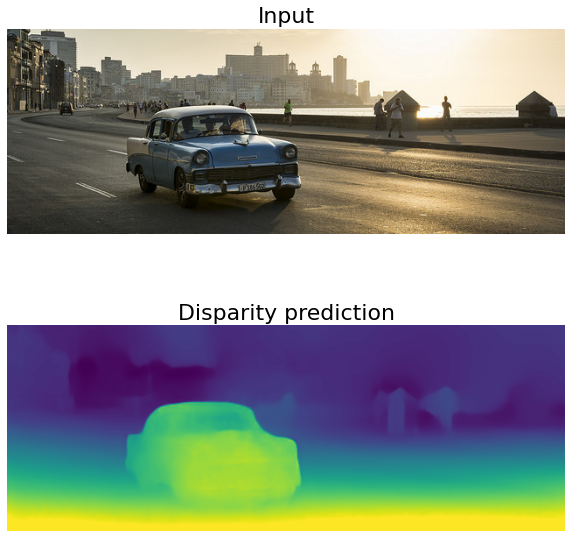

In [20]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='viridis', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');